<a href="https://colab.research.google.com/github/javsolmed/googledrive/blob/main/PRAC-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import ast

In [112]:
# Lectura de dataframes

df_2020 = pd.read_csv('df_2020.csv')
df_2021 = pd.read_csv('df_2021.csv')
df_2022 = pd.read_csv('df_2022.csv')


In [113]:
# Creación de funciones de limpieza

def clean_grade_column(dataframes):
    """
    Esta función toma una lista de DataFrames, elimina el símbolo '%' de la columna 'grade',
    y convierte la columna a tipo numérico.
    """
    for df in dataframes:
        df['grade'] = df['grade'].str.replace('%', '').astype(float)
    return

def clean_position_column(dataframes):
    """
    Esta función toma una lista de DataFrames, elimina el símbolo '#' de la columna 'position',
    y convierte la columna a tipo numérico.
    """
    for df in dataframes:
        df['position'] = df['position'].str.replace('#', '').astype(float)
    return dataframes

def clean_critics_column(dataframes):
    """
    Esta función toma una lista de DataFrames y elimina la frase 'Critics Consensus:'
    del inicio de la columna 'critics' si está presente.
    """
    for df in dataframes:
        df['critics'] = df['critics'].str.replace(r'^Critics Consensus: ', '', regex=True)
    return dataframes

def clean_synompsis_column(dataframes):
    """
    Esta función toma una lista de DataFrames y elimina la frase 'Synopsis: '
    del inicio de la columna 'synopsis' si está presente.
    """
    for df in dataframes:
        df['synopsis'] = df['synopsis'].str.replace(r'^Synopsis: ', '', regex=True)
    return dataframes

def clean_director_column(dataframes):
    """
    Esta función toma una lista de DataFrames y elimina la frase '\nDirected By: '
    del inicio de la columna 'director' si está presente.
    """
    for df in dataframes:
        df['director'] = df['director'].str.replace(r'^\nDirected By: ', '', regex=True)
    return dataframes


def clean_cast_column(dataframes):
    """
    Esta función toma una lista de DataFrames y convierte la columna 'cast' de listas escritas como cadenas
    a una cadena con los nombres separados por comas.
    """
    for df in dataframes:
        df['cast'] = df['cast'].apply(lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) else x)
    return dataframes


def explode_cast_column(dataframes):

    exploded_dfs = []
    for df in dataframes:
        df['cast'] = df['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
        exploded_df = df.explode('cast').reset_index(drop=True)
        exploded_dfs.append(exploded_df)
    combined_df = pd.concat(exploded_dfs, ignore_index=True)
    """
    Esta función toma una lista de DataFrames y desglosa la columna 'cast' en múltiples filas,
    una por cada actor, repitiendo el resto de la información.
    """
    return combined_df



In [114]:
# Aplicar las funciones a los DataFrames
dataframes = [df_2020, df_2021, df_2022]


dataframes = clean_position_column(dataframes)

dataframes = clean_critics_column(dataframes)

dataframes = clean_synompsis_column(dataframes)

dataframes = clean_director_column(dataframes)

dataframes = clean_cast_column(dataframes)

dataframes = clean_grade_column(dataframes)

In [133]:
# Filtrar las filas donde 'position' <= 100 (Para que todos tengan solo hasta el top 100)
df_2020 = df_2020[df_2020['position'] <= 100].sort_values(by='position', ascending=True)
df_2021 = df_2021[df_2021['position'] <= 100].sort_values(by='position', ascending=True)


# Unir los DataFrames por columna (unión vertical)
df_combined = pd.concat([df_2020, df_2021, df_2022], axis=0)

In [132]:
# Separar actores por fila
df = [df_combined]


df_combined_sep = explode_cast_column(df)

In [120]:
df_combined_sep.to_csv('df_combined_sep.csv', index=False)


In [121]:
df_combined.to_csv('df_combined.csv', index=False)


In [139]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = df_combined

# Eliminar filas con valores nulos en columnas clave
df.dropna(subset=['title', 'grade', 'critics', 'synopsis', 'director','cast'], inplace=True)

# Eliminar filas duplicadas
df = df.drop_duplicates()


ohe_director = OneHotEncoder(sparse=False)
director_encoded = ohe_director.fit_transform(df[['director']])
director_columns = ohe_director.get_feature_names_out(['director'])

# Vectorizar la sinopsis
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
synopsis_encoded = vectorizer.fit_transform(df['synopsis']).toarray()
synopsis_columns = vectorizer.get_feature_names_out()

# Crear DataFrames de las características codificadas y vectorizadas
director_df = pd.DataFrame(director_encoded, columns=director_columns)
synopsis_df = pd.DataFrame(synopsis_encoded, columns=synopsis_columns)

# Concatenar todas las características
X = pd.concat([df[['grade', 'year']].reset_index(drop=True),
               director_df.reset_index(drop=True),
               synopsis_df.reset_index(drop=True)], axis=1)

# Asegurarse de que todas las columnas tengan nombres de cadena
X.columns = X.columns.astype(str)

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Experimentar con diferentes números de clusters
num_clusters = 5  # Puedes ajustar este valor y experimentar

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualizar los clusters
print(df[['title', 'grade', 'year', 'cluster']])



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                     title  grade  year  cluster
240              His House  100.0  2020        2
239              Crip Camp  100.0  2020        2
238   Dick Johnson Is Dead   99.0  2020        2
237                   Host   99.0  2020        2
236              Driveways   99.0  2020        2
..                     ...    ...   ...      ...
95         What Josiah Saw   91.0  2022        2
96   The Tale of King Crab   90.0  2022        2
97                Alcarràs   93.0  2022        2
98                    Tove   90.0  2022        2
99            The Northman   90.0  2022        2

[288 rows x 4 columns]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1000x600 with 0 Axes>

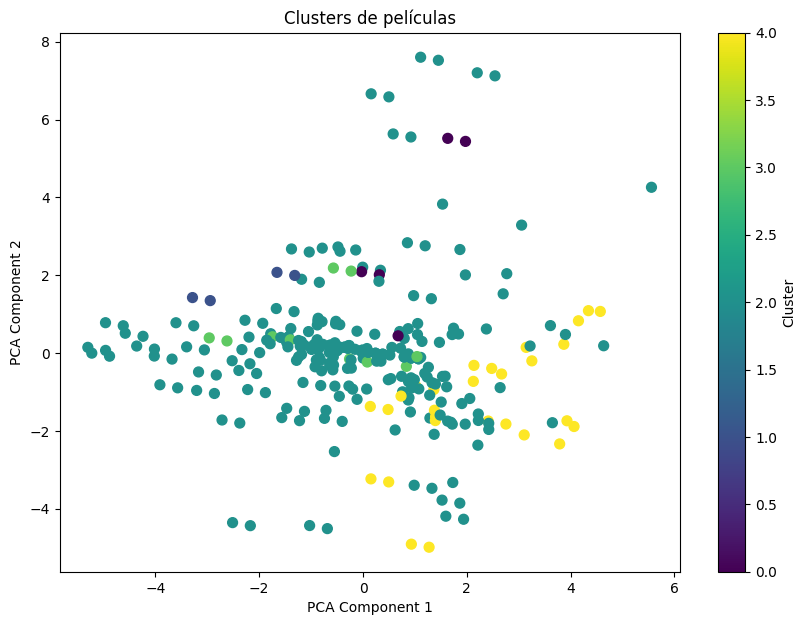

In [140]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducir la dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar los clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters de películas')
plt.colorbar(label='Cluster')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


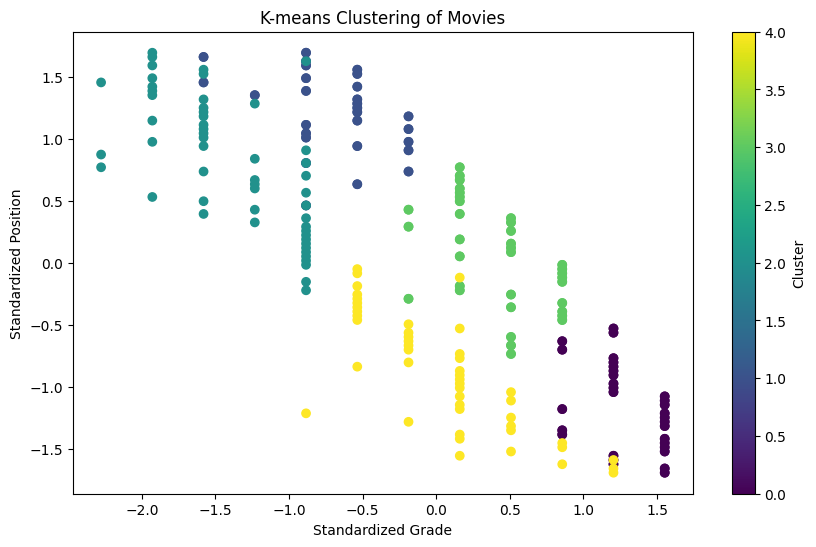

In [141]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cargar los datos
df = df_combined

# Seleccionar columnas relevantes
df_cluster = df[['grade', 'position', 'year']].drop_duplicates()

# Eliminar filas con valores nulos
df_cluster_clean = df_cluster.dropna()

# Estandarizar los datos
scaler = StandardScaler()
df_scaled_clean = scaler.fit_transform(df_cluster_clean)

# Aplicar K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster_clean['cluster'] = kmeans.fit_predict(df_scaled_clean)

# Visualizar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled_clean[:, 0], df_scaled_clean[:, 1], c=df_cluster_clean['cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering of Movies')
plt.xlabel('Standardized Grade')
plt.ylabel('Standardized Position')
plt.colorbar(label='Cluster')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


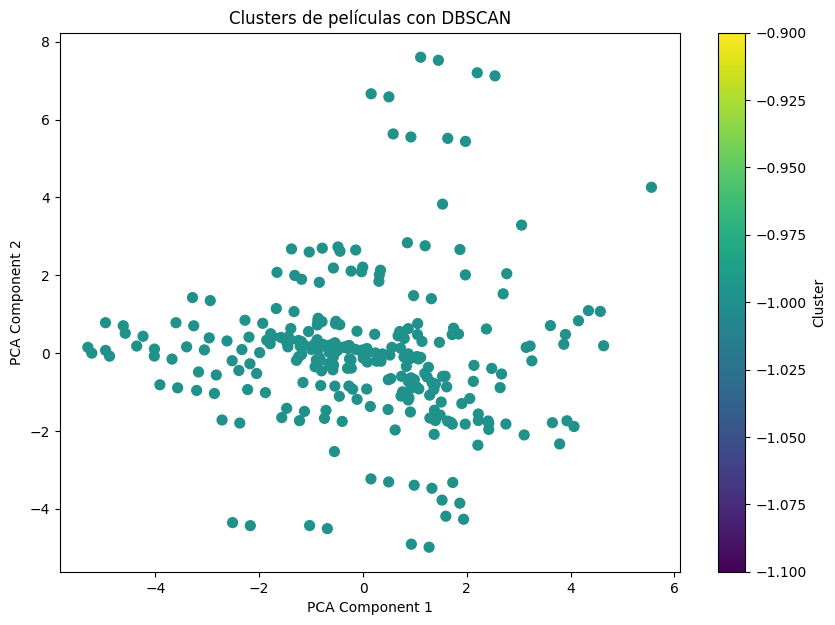

                                              title  grade  year  cluster
240                                       His House  100.0  2020       -1
239                                       Crip Camp  100.0  2020       -1
238                            Dick Johnson Is Dead   99.0  2020       -1
237                                            Host   99.0  2020       -1
236                                       Driveways   99.0  2020       -1
235                             Welcome to Chechnya  100.0  2020       -1
234                 All In: The Fight for Democracy  100.0  2020       -1
233  Mucho Mucho Amor: The Legend of Walter Mercado  100.0  2020       -1
232                                       Athlete A  100.0  2020       -1
231                                       City Hall   98.0  2020       -1


In [142]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Cargar datos
df = df_combined

# Eliminar filas con valores nulos en columnas clave
df.dropna(subset=['title', 'grade', 'critics', 'synopsis', 'director'], inplace=True)

# Eliminar filas duplicadas
df = df.drop_duplicates()

# Codificar características categóricas
ohe_cast = OneHotEncoder(sparse=False)

ohe_director = OneHotEncoder(sparse=False)
director_encoded = ohe_director.fit_transform(df[['director']])
director_columns = ohe_director.get_feature_names_out(['director'])

# Vectorizar la sinopsis
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
synopsis_encoded = vectorizer.fit_transform(df['synopsis']).toarray()
synopsis_columns = vectorizer.get_feature_names_out()

# Crear DataFrames de las características codificadas y vectorizadas

director_df = pd.DataFrame(director_encoded, columns=director_columns)
synopsis_df = pd.DataFrame(synopsis_encoded, columns=synopsis_columns)

# Concatenar todas las características
X = pd.concat([df[['grade', 'year']].reset_index(drop=True),
               director_df.reset_index(drop=True),
               synopsis_df.reset_index(drop=True)], axis=1)

# Asegurarse de que todas las columnas tengan nombres de cadena
X.columns = X.columns.astype(str)

# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5)
df['cluster'] = dbscan.fit_predict(X_scaled)

# Visualizar los clusters con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters de películas con DBSCAN')
plt.colorbar(label='Cluster')
plt.show()

# Visualizar los resultados
print(df[['title', 'grade', 'year', 'cluster']].head(10))


                    title  grade  year  sentiment
240             His House  100.0  2020  -0.033333
239             Crip Camp  100.0  2020   0.437500
238  Dick Johnson Is Dead   99.0  2020  -0.100000
237                  Host   99.0  2020   0.033333
236             Driveways   99.0  2020   0.150000


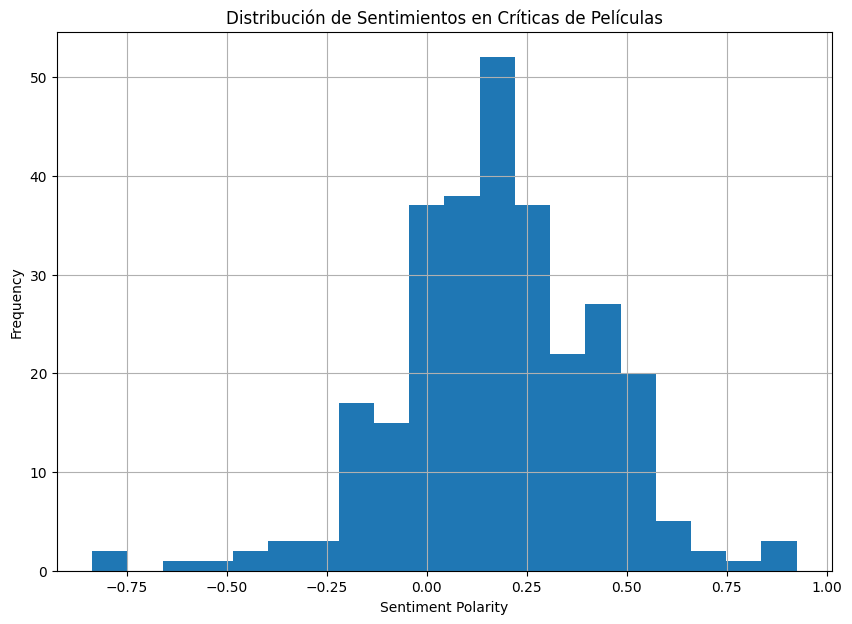

In [143]:
from textblob import TextBlob

df = df_combined


# Función para analizar el sentimiento de una crítica
def analyze_sentiment(critics):
    analysis = TextBlob(critics)
    return analysis.sentiment.polarity

# Aplicar el análisis de sentimientos a las críticas
df['sentiment'] = df['critics'].apply(analyze_sentiment)

# Visualizar los resultados
print(df[['title', 'grade', 'year', 'sentiment']].head())

# Graficar la distribución de los sentimientos
plt.figure(figsize=(10, 7))
df['sentiment'].hist(bins=20)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribución de Sentimientos en Críticas de Películas')
plt.show()


In [145]:
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado df con los datos de películas

# Función para comparar sentimiento con otras métricas
def comparar_metricas(df, metrica):
    resultados = {}
    for index, row in df.iterrows():
        año = row["year"]
        if año not in resultados:
            resultados[año] = {"positivo": 0, "negativo": 0}
        if row["sentiment"] >= 0:
            resultados[año]["positivo"] += row[metrica]
        else:
            resultados[año]["negativo"] += row[metrica]
    return resultados

# Comparación con la nota de la película
comparacion_nota = comparar_metricas(df, "grade")
print("Comparación con la nota de la película:")
for año, valores in comparacion_nota.items():
    print(f"Año {año}:")
    print(f"  Sentimiento positivo: {valores['positivo']}")
    print(f"  Sentimiento negativo: {valores['negativo']}")

# Comparación con la posición de la película
comparacion_position = comparar_metricas(df, "position")
print("\nComparación con la posición de la película:")
for año, valores in comparacion_position.items():
    print(f"Año {año}:")
    print(f"  Sentimiento positivo: {valores['positivo']}")
    print(f"  Sentimiento negativo: {valores['negativo']}")


Comparación con la nota de la película:
Año 2020:
  Sentimiento positivo: 7339.0
  Sentimiento negativo: 1743.0
Año 2021:
  Sentimiento positivo: 7339.0
  Sentimiento negativo: 1743.0
Año 2022:
  Sentimiento positivo: 7654.0
  Sentimiento negativo: 1698.0

Comparación con la posición de la película:
Año 2020:
  Sentimiento positivo: 3792.0
  Sentimiento negativo: 940.0
Año 2021:
  Sentimiento positivo: 3792.0
  Sentimiento negativo: 940.0
Año 2022:
  Sentimiento positivo: 4279.0
  Sentimiento negativo: 771.0


In [149]:
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado df con los datos de películas

# Función para determinar si un sentimiento es positivo o negativo
def categorizar_sentimiento(sentimiento):
    if sentimiento >= 0:
        return "positivo"
    else:
        return "negativo"

# Crear una columna 'categoría' en el DataFrame para almacenar la categoría de sentimiento
df['categoria'] = df['sentiment'].apply(categorizar_sentimiento)

# Crear una lista para almacenar los resultados
resultados = []

# Iterar sobre cada año
for año in df['year'].unique():
    # Obtener las 10 primeras películas de cada año
    top_10 = df[df['year'] == año].head(10)

    # Contar cuántas películas positivas y negativas hay entre las 10 primeras
    positivo_count = top_10[top_10['categoria'] == 'positivo'].shape[0]
    negativo_count = top_10[top_10['categoria'] == 'negativo'].shape[0]

    # Agregar los resultados a la lista
    resultados.append({'Año': año, 'Positivo': positivo_count, 'Negativo': negativo_count})

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados)

# Mostrar los resultados
print("Representación de sentimiento entre las 10 primeras películas de cada año:")
print(resultados_df)


Representación de sentimiento entre las 10 primeras películas de cada año:
    Año  Positivo  Negativo
0  2020         7         3
1  2021         7         3
2  2022         7         3


In [152]:
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado df con los datos de películas

# Función para determinar si un sentimiento es positivo o negativo
def categorizar_sentimiento(sentimiento):
    if sentimiento >= 0:
        return "positivo"
    else:
        return "negativo"

# Crear una columna 'categoría' en el DataFrame para almacenar la categoría de sentimiento
df['categoria'] = df['sentiment'].apply(categorizar_sentimiento)

# Mostrar el sentimiento real de las 10 primeras películas de cada año junto con su categoría
print("Sentimiento real de las 10 primeras películas de cada año:")
for año in df['year'].unique():
    print(f"Año {año}:")
    print(df[df['year'] == año].head(10)[['title', 'sentiment', 'categoria']])
    print()


Sentimiento real de las 10 primeras películas de cada año:
Año 2020:
                                              title  sentiment categoria
240                                       His House  -0.033333  negativo
239                                       Crip Camp   0.437500  positivo
238                            Dick Johnson Is Dead  -0.100000  negativo
237                                            Host   0.033333  positivo
236                                       Driveways   0.150000  positivo
235                             Welcome to Chechnya   0.450000  positivo
234                 All In: The Fight for Democracy   0.285714  positivo
233  Mucho Mucho Amor: The Legend of Walter Mercado   0.318750  positivo
232                                       Athlete A  -0.200000  negativo
231                                       City Hall   0.300000  positivo

Año 2021:
                                              title  sentiment categoria
240                                       Hi

In [153]:
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado df con los datos de películas

# Función para determinar si un sentimiento es positivo o negativo
def categorizar_sentimiento(sentimiento):
    if sentimiento >= 0:
        return "positivo"
    else:
        return "negativo"

# Crear una columna 'categoría' en el DataFrame para almacenar la categoría de sentimiento
df['categoria'] = df['sentiment'].apply(categorizar_sentimiento)

# Mostrar el sentimiento real de las 10 últimas películas de cada año junto con su categoría
print("Sentimiento real de las 10 últimas películas de cada año:")
for año in df['year'].unique():
    print(f"Año {año}:")
    print(df[df['year'] == año].tail(10)[['title', 'sentiment', 'categoria']])
    print()


Sentimiento real de las 10 últimas películas de cada año:
Año 2020:
                          title  sentiment categoria
150               Sylvie's Love   0.295833  positivo
149                   Babyteeth   0.333333  positivo
148                 The Outpost   0.196667  positivo
147               Ordinary Love   0.170833  positivo
146            Possessor: Uncut  -0.333333  negativo
145          And Then We Danced   0.500000  positivo
144  Bloody Nose, Empty Pockets  -0.200000  negativo
143                    Becoming   0.147222  positivo
142             End of Sentence   0.266667  positivo
141       We Are Little Zombies   0.270833  positivo

Año 2021:
                          title  sentiment categoria
150               Sylvie's Love   0.295833  positivo
149                   Babyteeth   0.333333  positivo
148                 The Outpost   0.196667  positivo
147               Ordinary Love   0.170833  positivo
146            Possessor: Uncut  -0.333333  negativo
145          And The

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Cargar los datos
datos = df_combined

# Eliminar filas con valores nulos en las columnas relevantes
datos.dropna(subset=['grade', 'critics', 'title', 'synopsis', 'director', 'position', 'year'], inplace=True)

# Seleccionar características y etiquetas
X_text = datos[['title', 'critics', 'synopsis', 'director']]
y = datos['grade']

# Combinar todas las características de texto en una sola columna
X_text['text_combined'] = X_text['title'] + ' ' + X_text['critics'] + ' ' + X_text['synopsis'] + ' ' + X_text['director']
X_text.drop(columns=['title', 'critics', 'synopsis', 'director'], inplace=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['text_combined'])
X_test_vectorized = vectorizer.transform(X_test['text_combined'])

# Entrenar un modelo de regresión lineal
regression_model = LinearRegression()
regression_model.fit(X_train_vectorized, y_train)

# Predecir las notas en el conjunto de prueba
y_pred = regression_model.predict(X_test_vectorized)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)


Error cuadrático medio: 3.2587734693661257


<ipython-input-161-7bf45acf5a98>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_text['text_combined'] = X_text['title'] + ' ' + X_text['critics'] + ' ' + X_text['synopsis'] + ' ' + X_text['director']
<ipython-input-161-7bf45acf5a98>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_text.drop(columns=['title', 'critics', 'synopsis', 'director'], inplace=True)


In [171]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Cargar los datos
datos = df_combined

# Eliminar filas con valores nulos en las columnas relevantes
datos.dropna(subset=['grade', 'critics', 'title', 'synopsis', 'director', 'position', 'year'], inplace=True)

# Seleccionar características y etiquetas
X_text = datos[[ 'critics',  'director']]
y = datos['grade']

# Combinar todas las características de texto en una sola columna
X_text['text_combined'] =  X_text['critics'] +  ' ' + X_text['director']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['text_combined'])
X_test_vectorized = vectorizer.transform(X_test['text_combined'])

# Entrenar un modelo de regresión lineal
regression_model = LinearRegression()
regression_model.fit(X_train_vectorized, y_train)

# Predecir las notas en el conjunto de prueba
y_pred = regression_model.predict(X_test_vectorized)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)


Error cuadrático medio: 3.5104890130335127


<ipython-input-171-b42381daf5ea>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_text['text_combined'] =  X_text['critics'] +  ' ' + X_text['director']


In [ ]:
# Supongamos que tienes un modelo entrenado llamado 'regression_model'

# Crear un DataFrame con los datos de la nueva película
nueva_pelicula = pd.DataFrame({
    'title': ['Ejemplo de película'],
    'critics': ['Una película emocionante y bien recibida por la crítica.'],
    'synopsis': ['Un grupo de amigos se aventura en una emocionante búsqueda.'],
    'director': ['Director Ejemplo'],
    'position': [1],
    'year': [2023]
})

# Combinar todas las características de texto en una sola columna
nueva_pelicula['text_combined'] = nueva_pelicula['title'] + ' ' + nueva_pelicula['critics'] + ' ' + nueva_pelicula['synopsis'] + ' ' + nueva_pelicula['director']

# Vectorizar el texto utilizando TF-IDF
nueva_pelicula_vectorized = vectorizer.transform(nueva_pelicula['text_combined'])

# Predecir la nota de la nueva película
nota_predicha = regression_model.predict(nueva_pelicula_vectorized)

print("Nota predicha para la nueva película:", nota_predicha)


In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Cargar los datos
datos = df_combined

# Eliminar filas con valores nulos en las columnas relevantes
datos.dropna(subset=['grade', 'critics', 'title', 'synopsis', 'director', 'position'], inplace=True)

# Seleccionar características y etiquetas
X_text = datos[[ 'critics', 'synopsis', 'director']]
y = datos['grade']

# Combinar todas las características de texto en una sola columna
X_text['text_combined'] =  ' ' + X_text['critics'] + ' ' + X_text['synopsis'] + ' ' + X_text['director']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['text_combined'])
X_test_vectorized = vectorizer.transform(X_test['text_combined'])

# Entrenar un modelo de Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_vectorized, y_train)

# Predecir las notas en el conjunto de prueba
y_pred = random_forest_model.predict(X_test_vectorized)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)


<ipython-input-170-a19bf79080dc>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_text['text_combined'] =  ' ' + X_text['critics'] + ' ' + X_text['director']


Error cuadrático medio: 5.03101724137931
